In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.stats.api as sms
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro
from scipy.stats import variation
import scipy.stats
from pylab import rcParams
import pmdarima as pm
from statsmodels.tsa.stattools import acf, pacf

# Préparation des données

In [281]:
xls = pd.ExcelFile('eCO2mix_RTE_energie_M_ok.xls') 
xls2 = pd.ExcelFile('DJU.xls') 

In [282]:
dataConsomElec = xls.parse(0)
DJU = xls2.parse(0)

## Sélection des données utiles 

In [283]:
dataConsomElecUtile = dataConsomElec[['Mois', 'Territoire',"Consommation totale"]]
dataConsomElecUtile['Mois'] = pd.to_datetime(dataConsomElecUtile['Mois'],format="%Y/%m")
dataConsomElecUtileFrance = dataConsomElecUtile[dataConsomElecUtile["Territoire"]== "France"]
dataConsomElecUtileRegion = dataConsomElecUtile[dataConsomElecUtile["Territoire"]!= "France"]

E:\Python\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [284]:
dataConsomElecUtileFrance.isna().sum()

Mois                   0
Territoire             0
Consommation totale    0
dtype: int64

In [285]:
dataConsomElecUtileRegion.isna().sum()

Mois                   0
Territoire             0
Consommation totale    0
dtype: int64

## Transformation DJU

In [286]:
d={}
c={}
DJUFinal=pd.DataFrame()
for i in DJU["Territoire"].unique():
    d[i] = DJU[DJU["Territoire"]==i].drop("Territoire", axis = 1)
    c[i]= pd.melt( d[i],id_vars=["Année"],value_vars =['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 'Jui', 'Aoû', 'Sep',
       'Oct', 'Nov', 'Déc'])
    c[i].replace({"Jan":"01", 'Fév':"02", 'Mar':"03", 'Avr':"04", 'Mai':"05", 'Jun':"06",
              'Jui':"07", 'Aoû':"08", 'Sep':"09",'Oct':"10", 'Nov':"11", 'Déc':"12"},inplace=True)
    c[i]["Mois"]= c[i]["Année"].astype(str)+"-"+c[i]["variable"]
    c[i] = c[i][["Mois","value"]]
    c[i].rename(columns={"value":"DJU"},inplace=True)
    c[i]["Territoire"]= i
                
    DJUFinal = pd.concat([DJUFinal,c[i]])

In [287]:
DJUFinal['Mois'] = pd.to_datetime(DJUFinal['Mois'])

In [288]:
DJUFinal.isnull().sum()

Mois          0
DJU           0
Territoire    0
dtype: int64

## Sélection des années  (2014 données accessibles pour le régions, à juin 2020 données DJU) 

In [289]:
# Selection de la période utile
start_date ="2014-01-01"
end_date= "2019-12-01"
dataConsomElecUtileFrance = dataConsomElecUtileFrance[(dataConsomElecUtileFrance['Mois'] >= start_date)\
                                                      & (dataConsomElecUtileFrance['Mois'] <= end_date)]
dataConsomElecUtileRegion =dataConsomElecUtileRegion[(dataConsomElecUtileRegion['Mois'] >= start_date)\
                                                     & (dataConsomElecUtileRegion['Mois'] <= end_date)]
DJUFinal = DJUFinal[(DJUFinal['Mois'] >= start_date) & (DJUFinal['Mois'] <= end_date)]

# Descritprion des données

## Plot 

### Consommation

E:\Python\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
E:\Python\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
E:\Python\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
E:\Python\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
E:\Python\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
E:\Python\lib\site-packag

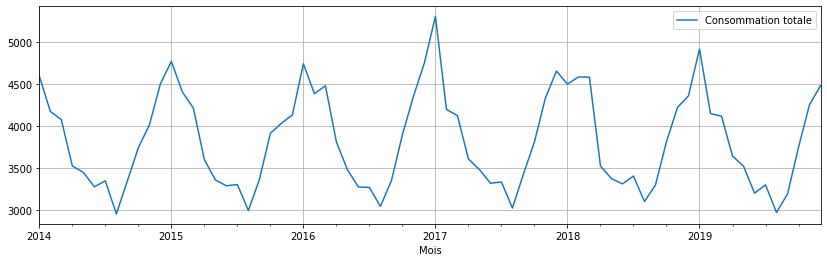

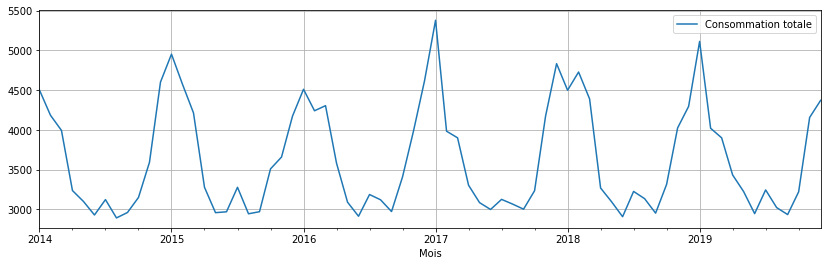

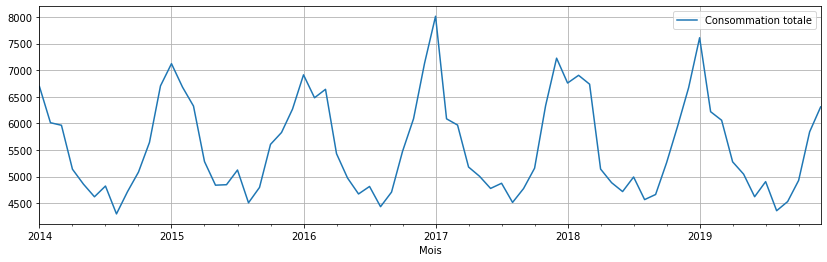

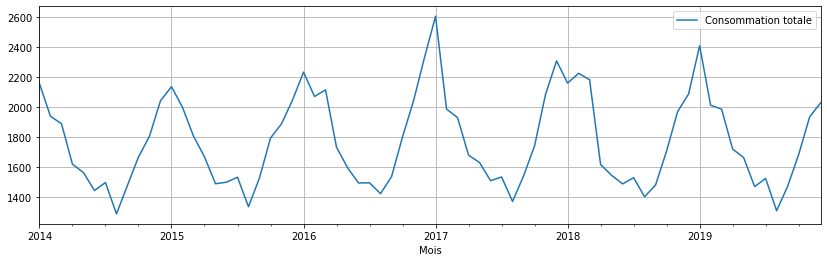

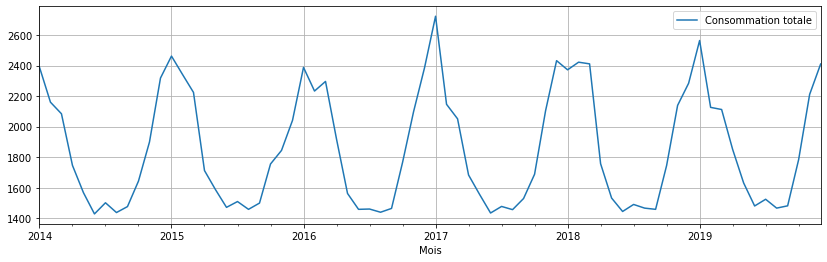

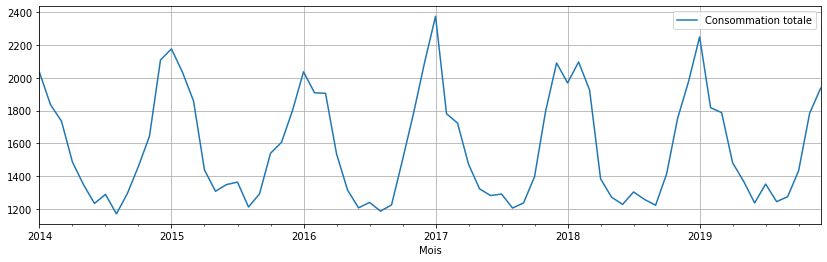

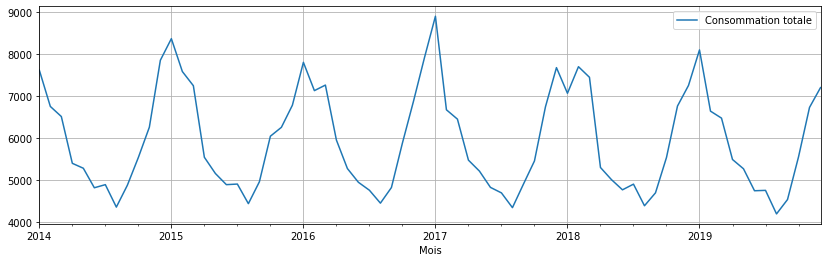

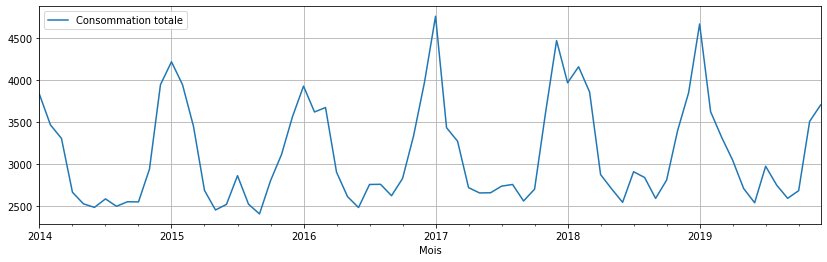

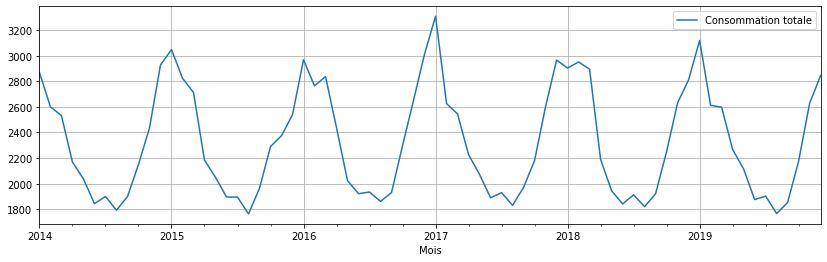

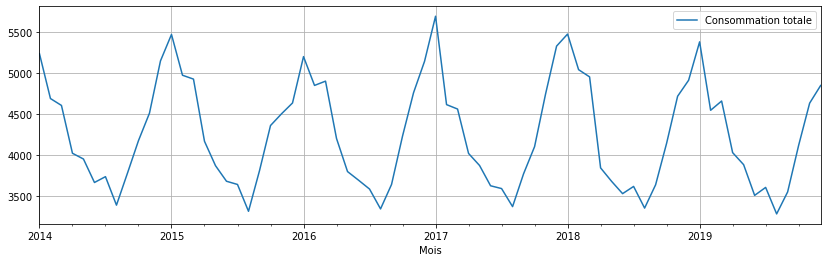

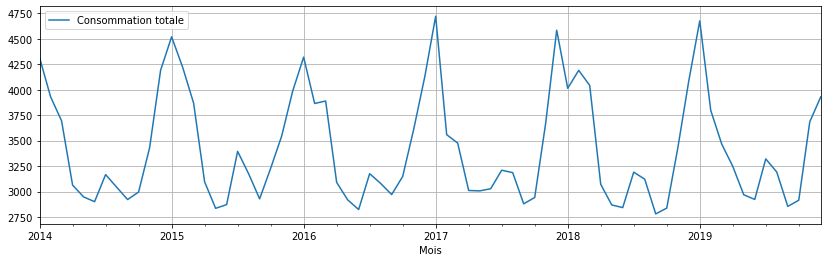

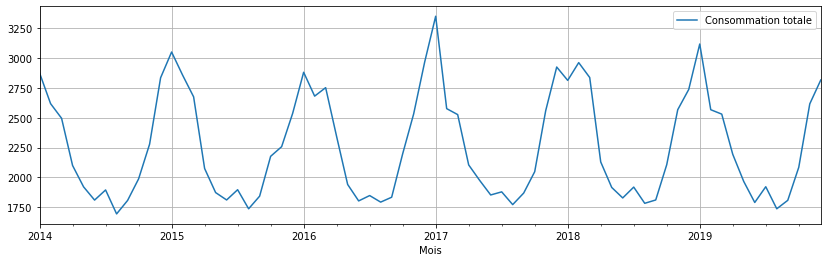

In [290]:
d={}
for i in dataConsomElecUtileRegion.Territoire.unique():
    d[i]= dataConsomElecUtileRegion[dataConsomElecUtileRegion["Territoire"]==i]
    fig = d[i].plot(y="Consommation totale",x='Mois', figsize=(14,4)).get_figure()
    plt.grid()
    fig.show()

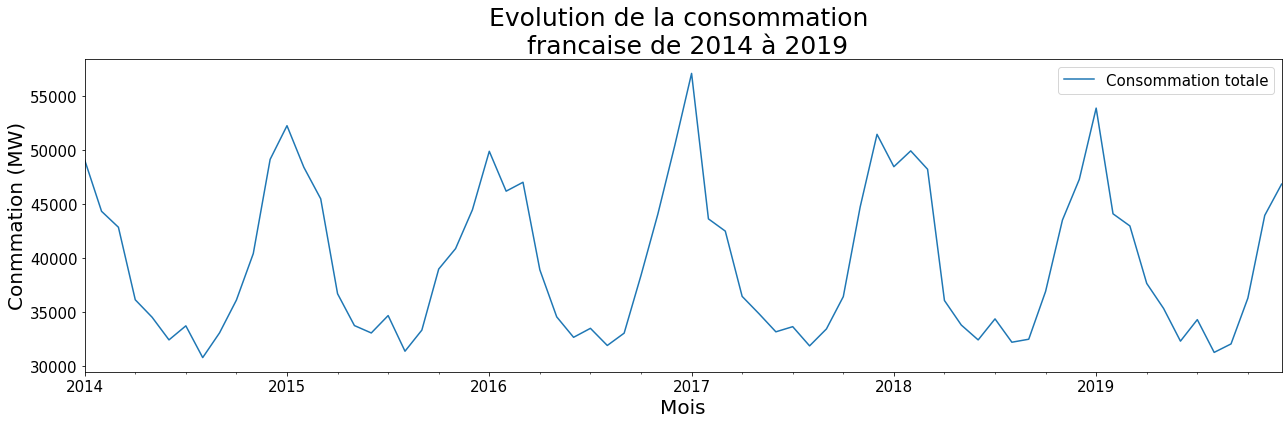

In [291]:
dataConsomElecUtileFrance = dataConsomElecUtileRegion.set_index("Mois")
dataConsomElecUtileFrance = dataConsomElecUtileFrance.groupby(pd.Grouper(freq="M")).sum()
fig = dataConsomElecUtileFrance.plot(y="Consommation totale", figsize=(18,6)).get_figure()
plt.title("Evolution de la consommation \n francaise de 2014 à 2019",fontsize = 25)
plt.ylabel("Date")
plt.ylabel("Conmmation (MW)")
axes= plt.gca()
fig.patch.set_alpha(0)
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('01_evo_conso_Francaise_2014_2019.png')

### DJU 

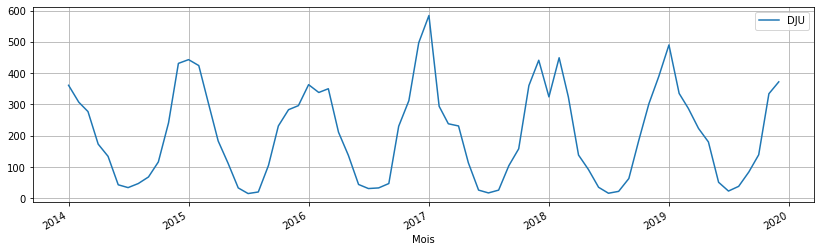

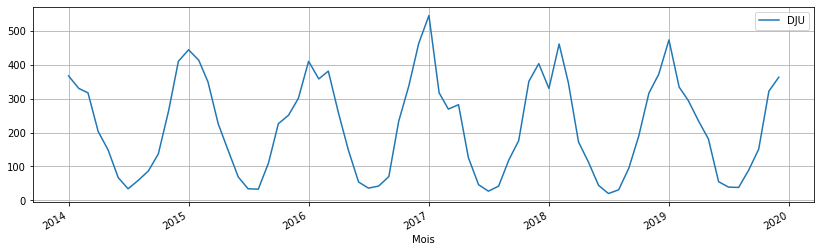

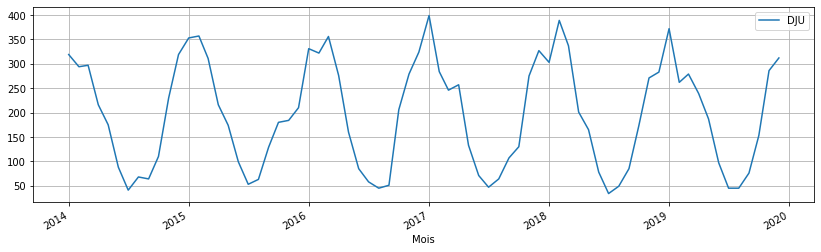

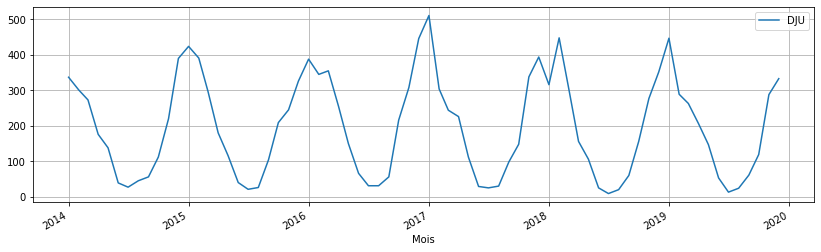

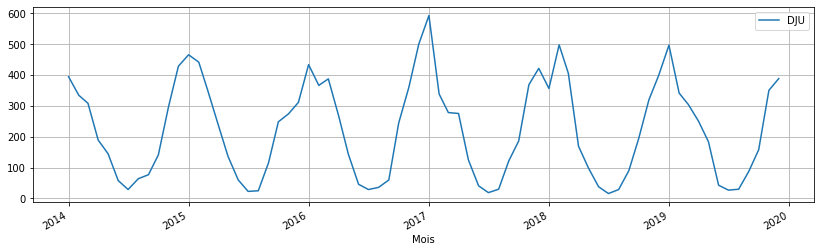

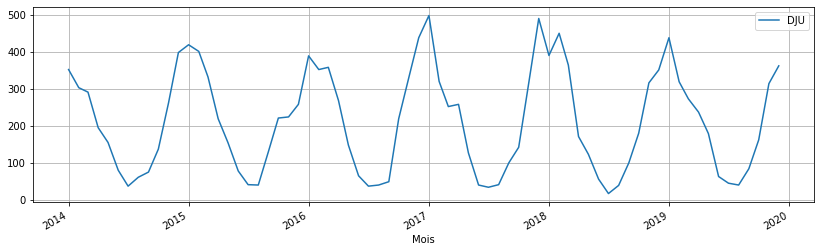

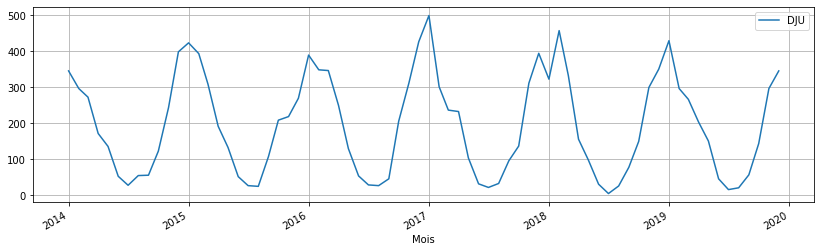

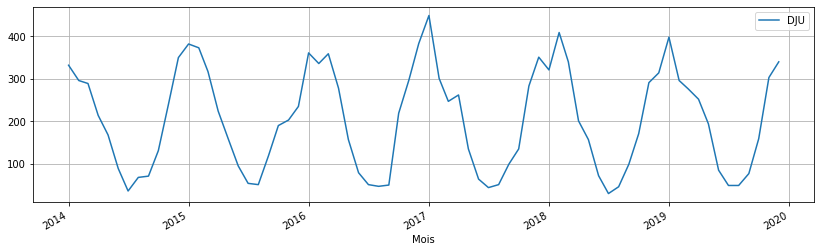

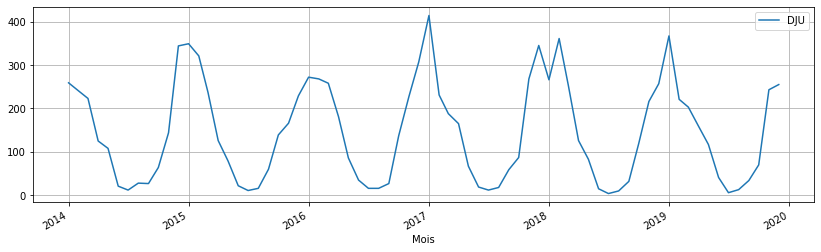

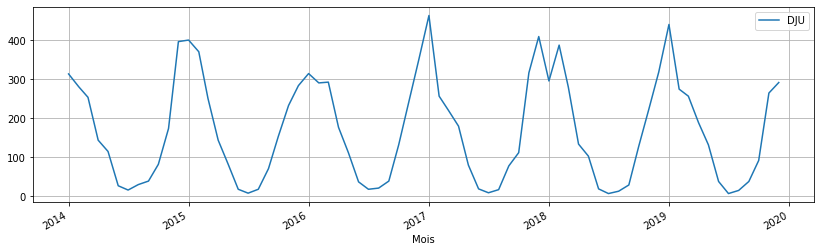

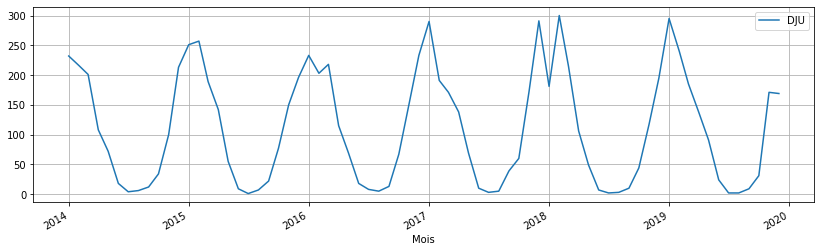

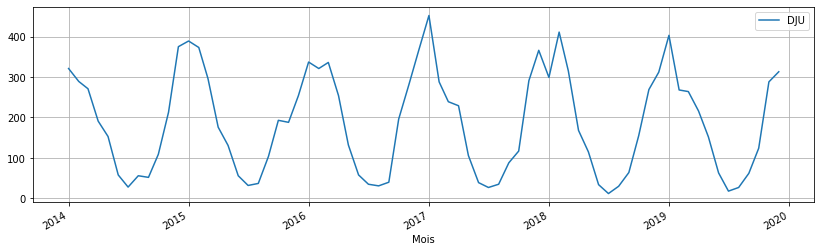

In [292]:
d={}
for i in DJUFinal.Territoire.unique():
    d[i]= DJUFinal[DJUFinal["Territoire"]==i]
    d[i].plot(y="DJU",x='Mois', figsize=(14,4))
    plt.grid()

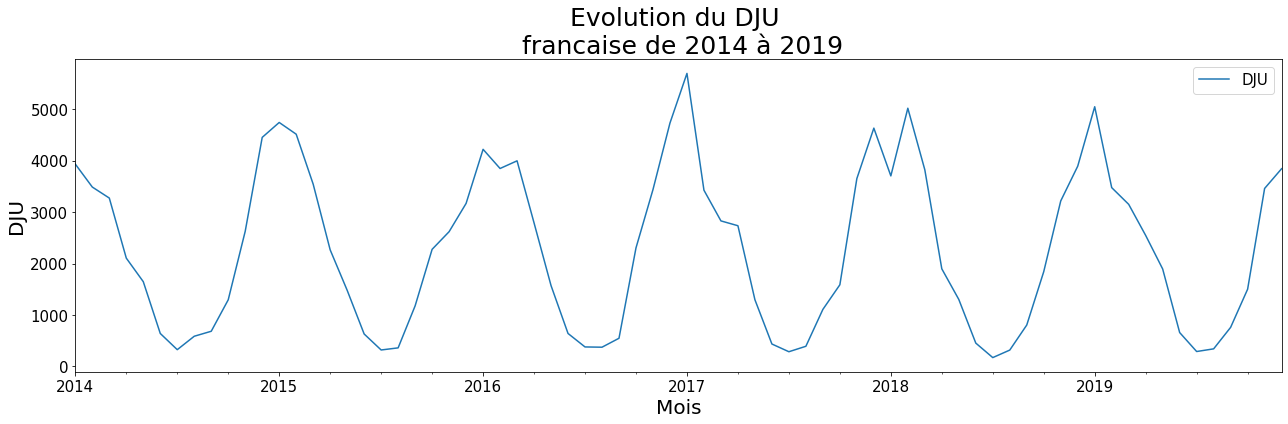

In [293]:
DJUfrance = DJUFinal.set_index("Mois")
DJUfrance = DJUfrance.groupby(pd.Grouper(freq="M")).sum()
fig=DJUfrance.plot(y="DJU", figsize=(18,6)).get_figure()
plt.title("Evolution du DJU \n francaise de 2014 à 2019",fontsize = 25)
plt.ylabel("Date")
plt.ylabel("DJU")
axes= plt.gca()
fig.patch.set_alpha(0)
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('02_evo_DJU_en_France_2014_2019.png')

- xx semble Additif car pas de croissance au fil d'une année à l'autre
- DJU et Conso suive la même saisonnalité faible en été, pic en hiver janvier
- Remontée d'été : Juilllet plus bas Aout spetembre 

## Chiffrée

### Consommation

In [294]:
dataConsomElecUtileFrance.reset_index(inplace=True)
dataConsomElecUtileFrance["Month"]=dataConsomElecUtileFrance.Mois.dt.month
dataConsomElecUtileFrance.groupby("Month").agg(["mean","std"])

Consommation totale             
                     mean          std
Month                                 
1            51812.666667  3313.045950
2            46131.833333  2577.926874
3            44876.333333  2430.518930
4            37018.166667  1100.614631
5            34499.000000   611.398397
6            32707.333333   363.313455
7            34066.833333   475.370347
8            31599.500000   521.011612
9            32936.500000   533.685207
10           37221.333333  1207.627536
11           42961.166667  1816.212809
12           48303.500000  2565.802545

### DJU 

In [295]:
DJUfrance.reset_index(inplace=True)
DJUfrance["Month"]=DJUfrance.Mois.dt.month
DJUfrance.groupby("Month").agg(["mean","std"])

DJU            
              mean         std
Month                         
1      4557.833333  749.151097
2      3962.000000  661.405473
3      3436.000000  436.390192
4      2389.833333  358.611442
5      1531.666667  226.755081
6       576.000000  102.802724
7       294.500000   69.102098
8       394.666667   97.165152
9       846.333333  246.376676
10     1800.833333  417.647419
11     3169.000000  444.480821
12     4120.666667  596.775558

# Question 1 Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.

## Préparation des données

In [296]:
#jointure region et DJU
dataQ1 = pd.merge(dataConsomElecUtileRegion,DJUFinal, on =['Mois',"Territoire"])
dataQ1 = dataQ1.groupby("Mois").sum()
dataQ1.reset_index(inplace = True)

In [297]:
dataQ1.head()

,Mois,Consommation totale,DJU
0,2014-01-01,49110,3933
1,2014-02-01,44364,3487
2,2014-03-01,42888,3273
3,2014-04-01,36169,2105
4,2014-05-01,34551,1647


In [298]:
#ajout des t pour la regression linéaire
dataQ1["t"]= range(1, dataQ1.shape[0]+1)

## Premier apercu de la relation 

const    29820.723579
DJU          4.294252
dtype: float64


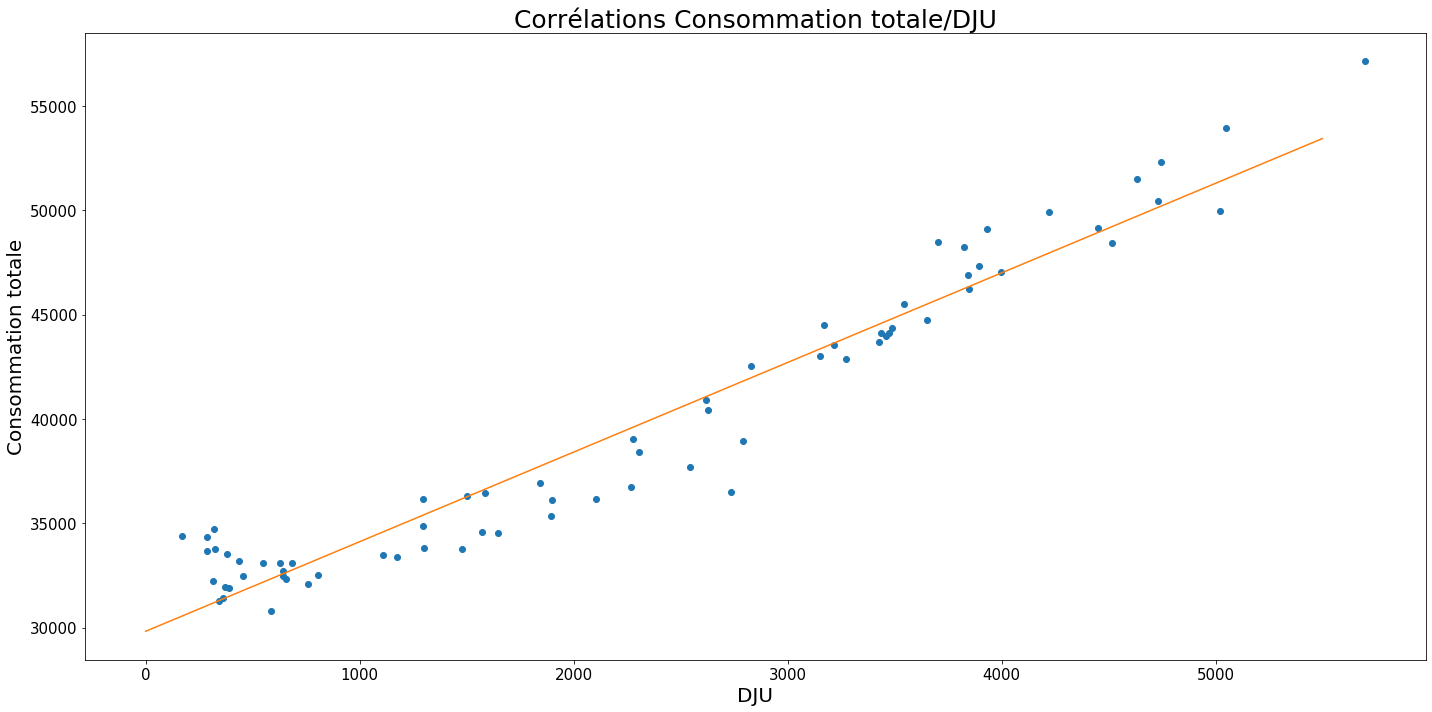

In [299]:
Yams = dataQ1['Consommation totale']
Xams = dataQ1[['DJU']]
Xams = sm.add_constant(Xams)
moindreCareAms = sm.OLS(Yams, Xams).fit() # OLS = Ordinary Least Square (Moindres Carrés Ordinaire)
a,b = moindreCareAms.params['DJU'],moindreCareAms.params['const']

print(moindreCareAms.params)

fig = plt.figure(1, figsize=(20, 10))
axes = plt.gca()
plt.plot(dataQ1.DJU,dataQ1['Consommation totale'], "o")
plt.plot(np.arange(0,5500),[a*x+b for x in np.arange(0,5500)])
plt.title("Corrélations Consommation totale/DJU",fontsize = 25)
plt.xlabel("DJU",fontsize = 20)
plt.ylabel("Consommation totale",fontsize = 20)
axes.yaxis.set_tick_params (labelsize =15)
axes.xaxis.set_tick_params (labelsize =15)
fig.patch.set_alpha(0)
plt.tight_layout()
plt.savefig('03_correlation_conso_DJU.png')
plt.show()

## Regression Linéaire

In [300]:
#prepa donnée pour la regression linéaire
y=dataQ1['Consommation totale']
x=dataQ1[["t","DJU"]]

In [301]:
#regression linéaire
reg = linear_model.LinearRegression(fit_intercept=True)
regression=reg.fit(x, y)
regression

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [302]:
print(reg.coef_,reg.intercept_)

[3.59688075 4.29558045] 29686.43984615614


In [303]:
# appelation du coeff
coeff = reg.coef_[1]

In [304]:
#application du coeff trouvé 
dataQ1["Consomation corrigée"] = dataQ1['Consommation totale'] - dataQ1['DJU']*coeff

In [305]:
dataQ1Final = dataQ1.groupby("Mois").sum()

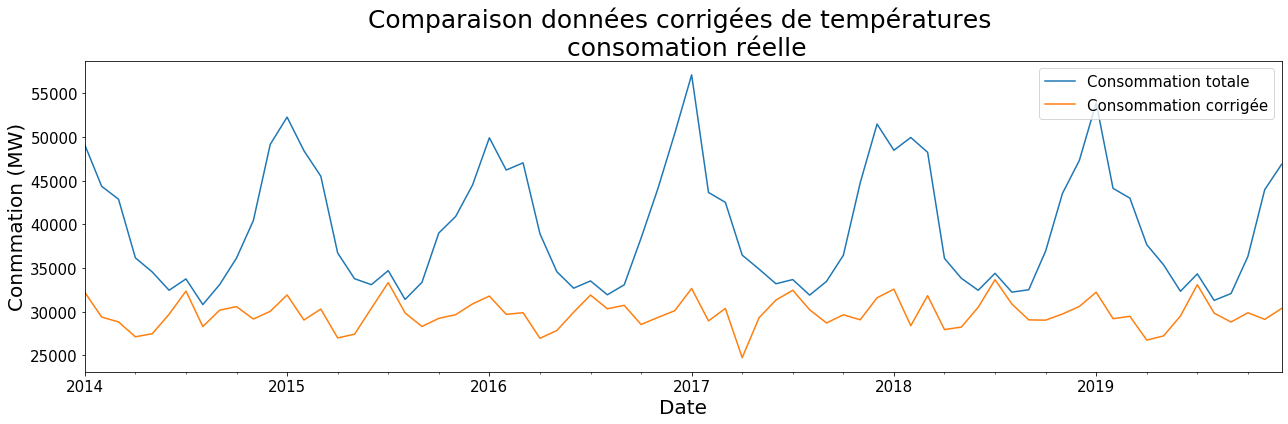

In [306]:
dataQ1Final['Consommation totale'].plot(figsize=(18,6),label="Consommation totale")
fig = dataQ1Final["Consomation corrigée"].plot(label='Consommation corrigée').get_figure()
plt.title("Comparaison données corrigées de températures \n consomation réelle",fontsize = 25)
plt.xlabel("Date")
plt.ylabel("Conmmation (MW)")
axes= plt.gca()
fig.patch.set_alpha(0)
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('04_graphique_Q1.png')

In [307]:
print(variation(dataQ1Final['Consomation corrigée'].values))
print(variation(dataQ1Final['Consommation totale'].values))

0.05742830151280522
0.17330052055162537


## Vérification de la regression linéaire

In [308]:
print(moindreCareAms.summary())

                             OLS Regression Results                            
Dep. Variable:     Consommation totale   R-squared:                       0.937
Model:                             OLS   Adj. R-squared:                  0.937
Method:                  Least Squares   F-statistic:                     1049.
Date:                 Sat, 12 Dec 2020   Prob (F-statistic):           7.20e-44
Time:                         09:20:20   Log-Likelihood:                -638.25
No. Observations:                   72   AIC:                             1280.
Df Residuals:                       70   BIC:                             1285.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.982e+04    362.470     82.27

### Normalité des résidus

In [309]:
y_pred= moindreCareAms.predict(Xams)

In [310]:
residual = Yams-y_pred

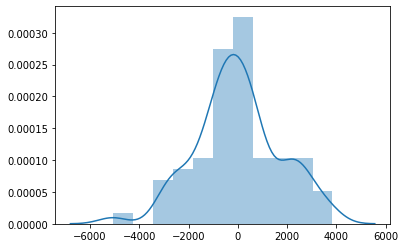

In [311]:
sns.distplot(residual)

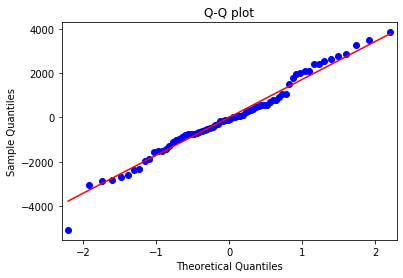

In [312]:
sm.ProbPlot(residual).qqplot(line='s');
plt.title('Q-Q plot');

In [313]:
np.mean(residual)

-1.0105496686365869e-13

In [314]:
jb = stats.jarque_bera(residual)
sw = stats.shapiro(residual)
ad = stats.anderson(residual, dist='norm')
ks = stats.kstest(residual, 'norm')
    
print(f'Jarque-Bera test ---- statistic: {jb[0]:.4f}, p-value: {jb[1]}')
print(f'Shapiro-Wilk test ---- statistic: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
print(f'Kolmogorov-Smirnov test ---- statistic: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
print(f'Anderson-Darling test ---- statistic: {ad.statistic:.4f}, 5% critical value: {ad.critical_values[2]:.4f}')

Jarque-Bera test ---- statistic: 0.1085, p-value: 0.9472008073303904
Shapiro-Wilk test ---- statistic: 0.9840, p-value: 0.4922
Kolmogorov-Smirnov test ---- statistic: 0.5139, p-value: 0.0000
Anderson-Darling test ---- statistic: 0.4442, 5% critical value: 0.7490


### Homoscedasticité (ligne droite pas de patern)

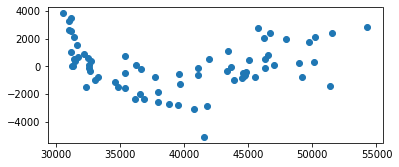

In [315]:
fig, ax = plt.subplots(figsize= (6,2.5))
_=ax.scatter(y_pred,residual)


 Breusch-Pagan test ----
                                  value
Lagrange multiplier statistic  0.093780
p-value                        0.759425
f-value                        0.091294
f p-value                      0.763434

 Goldfeld-Quandt test ----
                value
F statistic  1.386897
p-value      0.172458

 Residuals plots ----


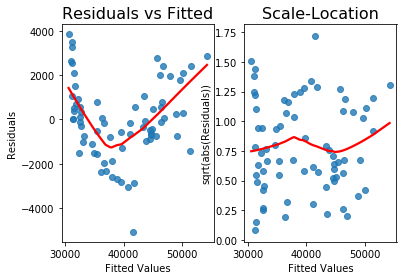

In [316]:
def homoscedasticity_test(model):
    '''
    Function for testing the homoscedasticity of residuals in a linear regression model.
    It plots residuals and standardized residuals vs. fitted values and runs Breusch-Pagan and Goldfeld-Quandt tests.
    
    Args:
    * model - fitted OLS model from statsmodels
    '''
    fitted_vals = model.predict()
    resids = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal

    fig, ax = plt.subplots(1,2)

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuals vs Fitted', fontsize=16)
    ax[0].set(xlabel='Fitted Values', ylabel='Residuals')

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set(xlabel='Fitted Values', ylabel='sqrt(abs(Residuals))')

    bp_test = pd.DataFrame(sms.het_breuschpagan(resids, model.model.exog), 
                           columns=['value'],
                           index=['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value'])

    gq_test = pd.DataFrame(sms.het_goldfeldquandt(resids, model.model.exog)[:-1],
                           columns=['value'],
                           index=['F statistic', 'p-value'])

    print('\n Breusch-Pagan test ----')
    print(bp_test)
    print('\n Goldfeld-Quandt test ----')
    print(gq_test)
    print('\n Residuals plots ----')

homoscedasticity_test(moindreCareAms)

### autocorrélation (pas de valeur au dessus du bleu)

E:\Python\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


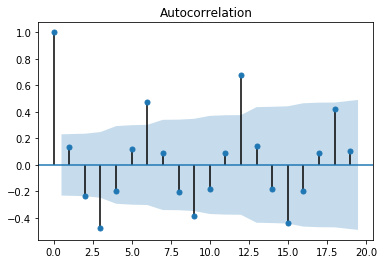

In [317]:
acf= smt.graphics.plot_acf(residual, alpha =0.05)
acf.show()

# Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.

## Décomposition 

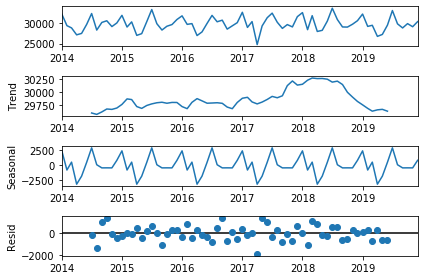

In [318]:
decomp_x = seasonal_decompose(dataQ1Final[["Consomation corrigée"]],  model='additive')
decomp_x.plot().get_figure()
axes= plt.gca()
fig.patch.set_alpha(0)
plt.tight_layout()
plt.savefig('05_Décomposition.png')
plt.show()

## Désaisonalisation

In [319]:
dataQ1Final['Consommation corr saison']=dataQ1Final["Consomation corrigée"].values-decomp_x.seasonal.values

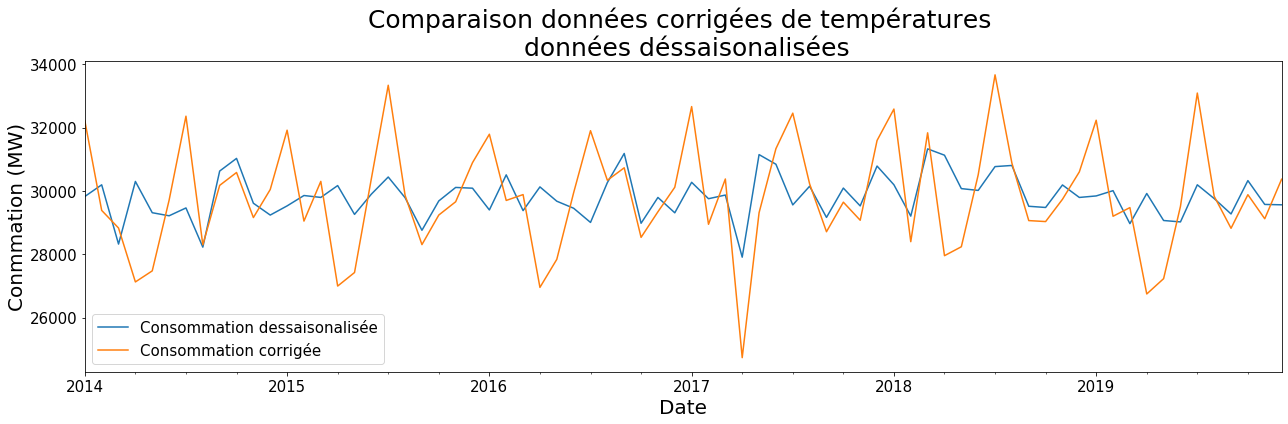

In [320]:
fig = plt.figure(figsize=(18,6))
dataQ1Final['Consommation corr saison'].plot(figsize=(18,6),label="Consommation dessaisonalisée")
dataQ1Final["Consomation corrigée"].plot(label='Consommation corrigée').get_figure()
plt.title("Comparaison données corrigées de températures \n données déssaisonalisées",fontsize = 25)
plt.xlabel("Date")
plt.ylabel("Conmmation (MW)")
axes= plt.gca()
fig.patch.set_alpha(0)
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('06_graphique_Q2.png')


## Analyse (Taux de variation)

In [321]:
variation(dataQ1Final['Consommation corr saison'].values)

0.022839414237413074

In [322]:
variation(dataQ1Final['Consomation corrigée'].values)

0.05742830151280522

## Verification (bruit blanc)

- moyenne et variance du signal constant et indépendant du temps 
- auto-correlation de la serie temporelle et la version lag dela serie est 0

### Serie corrigée 

In [323]:
shapiro(dataQ1Final['Consomation corrigée'])

(0.9840366244316101, 0.49537894129753113)

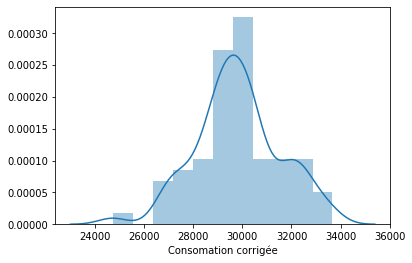

In [324]:
sns.distplot(dataQ1Final['Consomation corrigée'])

In [325]:
#lungbox test (not white noise p<0.05)
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(dataQ1Final['Consomation corrigée'],lags=elt)[1].mean()))

6 : 0.04764412917136542
12 : 0.023822074269388562
18 : 0.01588138284625905
24 : 0.011911037134694285
30 : 0.009528829707755428
36 : 0.007940691423129524


E:\Python\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


E:\Python\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


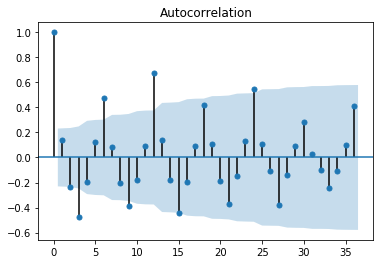

In [326]:
#auto-corrélation serie/lag
acf= smt.graphics.plot_acf(dataQ1Final['Consomation corrigée'], lags=36)
acf.show()

### Serie corrigée et désaisonalisée

In [327]:
shapiro(dataQ1Final['Consommation corr saison'])

(0.9835395216941833, 0.46876364946365356)

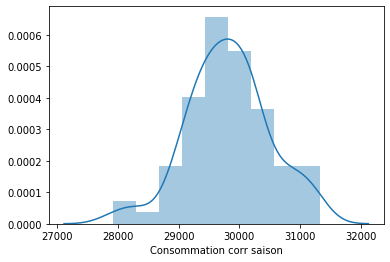

In [328]:
sns.distplot(dataQ1Final['Consommation corr saison'])

In [329]:
#lungbox test (not white noise p<0.05)
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(dataQ1Final['Consommation corr saison'],lags=elt)[1].mean()))

6 : 0.43384514324069
12 : 0.4123797487839376
18 : 0.3422576429360732
24 : 0.2765534886544823
30 : 0.22873228456138583
36 : 0.19278357089523887


E:\Python\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


E:\Python\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


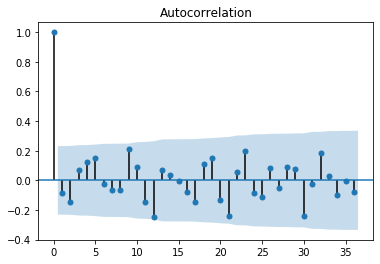

In [330]:
#auto-corrélation serie/lag
acf= smt.graphics.plot_acf(dataQ1Final['Consommation corr saison'], lags=36)
acf.show()

# Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.

## Méthode de Holt Winters (lissage exponentiel)

### Prévision

In [331]:
dataQ1Final.reset_index(inplace=True)

In [332]:
dataQ1FinalPrev = dataQ1Final[dataQ1Final['Mois']<"2019-01-01"].set_index("Mois")
dataQ1FinalReel = dataQ1Final[dataQ1Final['Mois']>="2019-01-01"].set_index("Mois")

E:\Python\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
E:\Python\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub
E:\Python\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


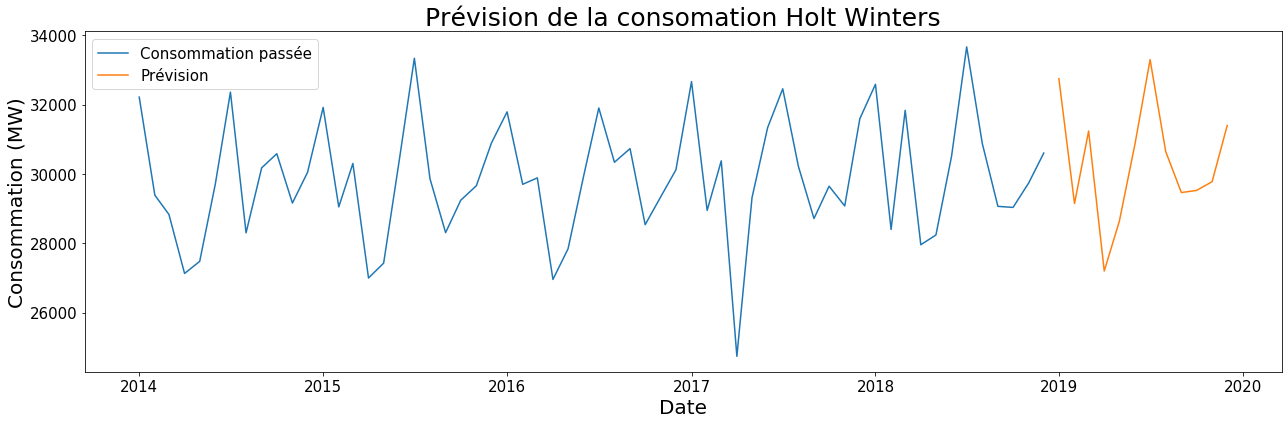

In [333]:
hw = ExponentialSmoothing(np.asarray(dataQ1FinalPrev["Consomation corrigée"]),
                          seasonal_periods=12,
                          trend='add',
                          seasonal='add').fit()
hw_pred = hw.forecast(12)

fig=plt.figure(figsize=(18,6))
plt.plot(dataQ1FinalPrev["Consomation corrigée"], label='Consommation passée')
plt.plot(pd.date_range(dataQ1FinalPrev.index[len(dataQ1FinalPrev)-1], periods=12, freq='M'), hw_pred, label='Prévision')
plt.title("Prévision de la consomation Holt Winters",fontsize = 25)
plt.xlabel("Date")
plt.ylabel("Consommation (MW)")
axes= plt.gca()
fig.patch.set_alpha(0)
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.legend(fontsize=15)
plt.savefig('07_graphique_Q3_1.png')
plt.show()

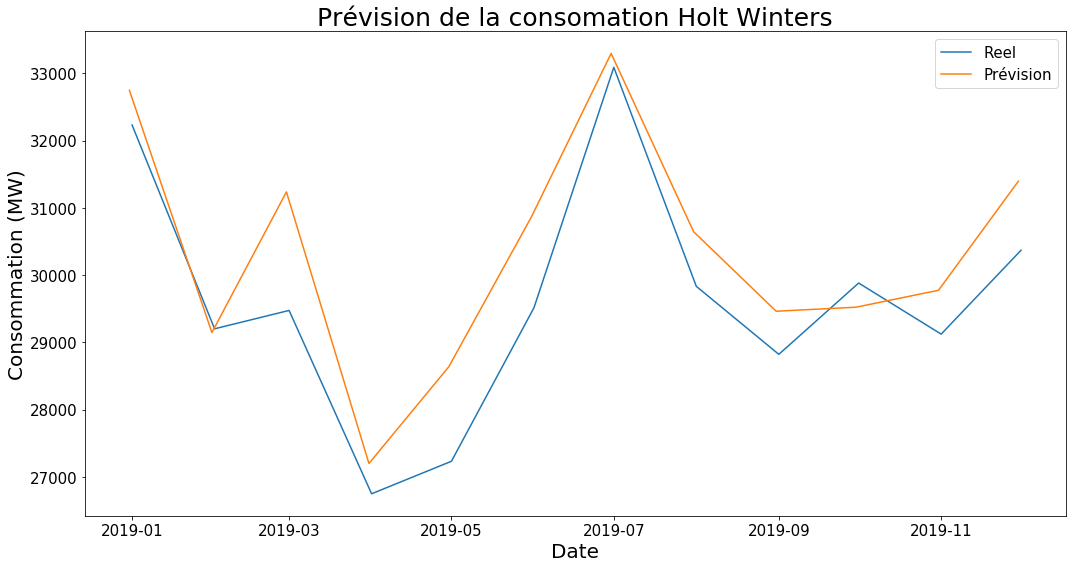

In [334]:
fig=plt.figure(figsize=(15,8))
plt.plot(dataQ1FinalReel["Consomation corrigée"], label='Reel')
plt.plot(pd.date_range(dataQ1FinalPrev.index[len(dataQ1FinalPrev)-1], periods=12, freq='M'), hw_pred, label='Prévision')
plt.title("Prévision de la consomation Holt Winters",fontsize = 25)
plt.xlabel("Date")
plt.ylabel("Consommation (MW)")
axes= plt.gca()
fig.patch.set_alpha(0)
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.legend(fontsize=15)
plt.savefig('08_prev_reel_HW.png')
plt.show()

In [335]:
dataQ1FinalReel["Consomation corrigée"].values

array([32232.61433036, 29200.56237123, 29473.62601604, 26746.4521856 ,
       27230.17063611, 29513.50806682, 33090.57725123, 29832.20706806,
       28820.65444182, 29881.33375121, 29121.29165836, 30368.78876726])

### Analyse des paramètres 

In [336]:
#aplha 
hw.params

{'smoothing_level': 0.05263157894736842,
 'smoothing_slope': 0.05263157894736842,
 'smoothing_seasonal': 0.47368421052631576,
 'damping_slope': nan,
 'initial_level': 32234.42944497751,
 'initial_slope': 13.961282848368413,
 'initial_seasons': array([  -18.94733737, -2849.11845865, -3405.8642433 , -5107.62628288,
        -4758.25043882, -2527.60093014,   125.50691022, -3935.63958608,
        -2059.3108893 , -1652.20612198, -3075.21485591, -2189.64916906]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

- alpha 0.052 : Valeur faible donc prévision à partir de l'ensemble des données pas que les plus récentes
- beta 0.052 : Valeur faible donc prévision sur l'ensemble des tendances et pas que les plus récentes
- Gamma 0.47 : valeur assez élevée donc utilisation des paternes de saisonnalité récentes

### MAPE (Mean Absolute Percentage Error)

In [337]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [338]:
mape (dataQ1FinalReel["Consomation corrigée"].values,hw_pred)

2.632005914970815

## SARIMA

### Stationnarisation 

In [339]:
def plot_sortie_acf( y_acf, y_len,title,num, pacf=False):
    "représentation de la sortie ACF"
    if pacf:
        y_acf = y_acf[1:]
    fig = plt.figure(figsize=(14,6))
    plt.bar(range(len(y_acf)), y_acf, width = 0.1)
    plt.xlabel('lag')
    plt.ylabel('ACF')
    if pacf:
        plt.ylabel('PACF')
    plt.axhline(y=0, color='black')
    plt.axhline(y=-1.96/np.sqrt(y_len), color='b', linestyle='--', linewidth=0.8)
    plt.axhline(y=1.96/np.sqrt(y_len), color='b', linestyle='--', linewidth=0.8)
    plt.ylim(-1, 1)
    plt.title(title,fontsize = 25)
    fig.patch.set_alpha(0)
    axes= plt.gca()
    axes.xaxis.label.set_size(20)
    axes.yaxis.label.set_size(20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.savefig(num+"_"+title+".png")
    plt.show()
    return

E:\Python\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


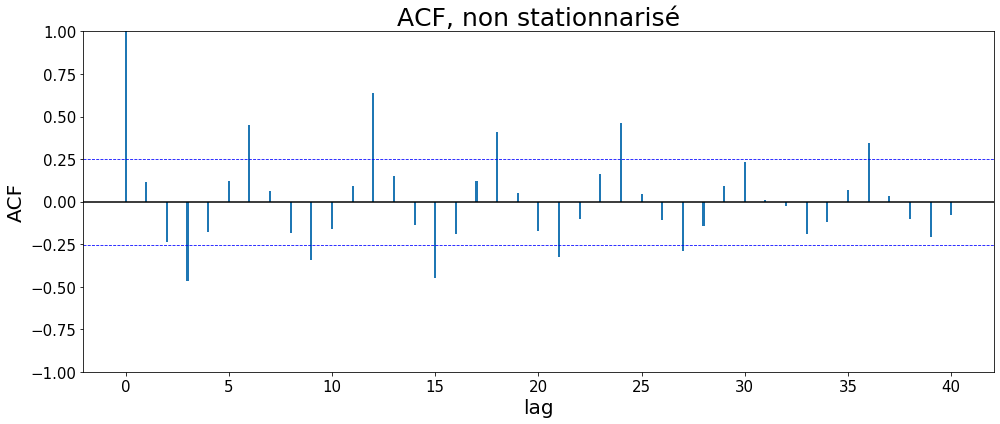

In [340]:
from statsmodels.tsa.stattools import acf, pacf
y_len = len(dataQ1FinalPrev["Consomation corrigée"]) # variable nécessaire pour l'utilisation de plot_sortie_acf

plot_sortie_acf(acf(np.asarray(dataQ1FinalPrev["Consomation corrigée"])), y_len,"ACF, non stationnarisé","09")


La sortie ACF de la série ainsi différenciée présente encore une décroissance lente vers 0 pour les multiples de 12. On effectue cette fois la différenciation $(I−B^{12})$ .

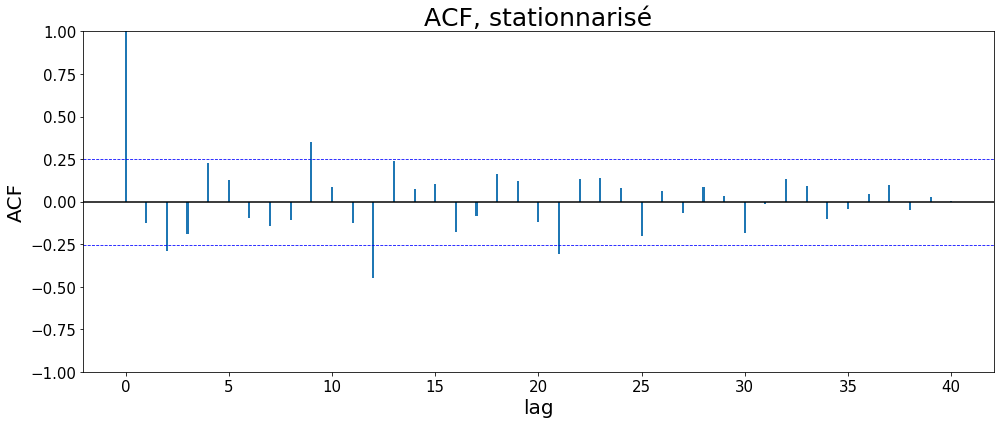

In [341]:
y_dif_12 = dataQ1FinalPrev["Consomation corrigée"] - dataQ1FinalPrev["Consomation corrigée"].shift(12)

plot_sortie_acf(acf(np.asarray(y_dif_12[13:])), y_len,"ACF, stationnarisé","10")

In [342]:
#adfuller si <0.05 rejet de H0 "la serie n'est pas stationnaire"
adfuller(y_dif_12[12:])[1] 

2.315054117896065e-08

Série devient stationnaire donc d=0 et D=1

In [343]:
adfuller(dataQ1FinalPrev["Consomation corrigée"])[1] 

0.7297773656827486

### Identification des modèles   (p,d,q)(P,D,Q,S)

#### Identification  manuelle 1  (ACF et PACF)

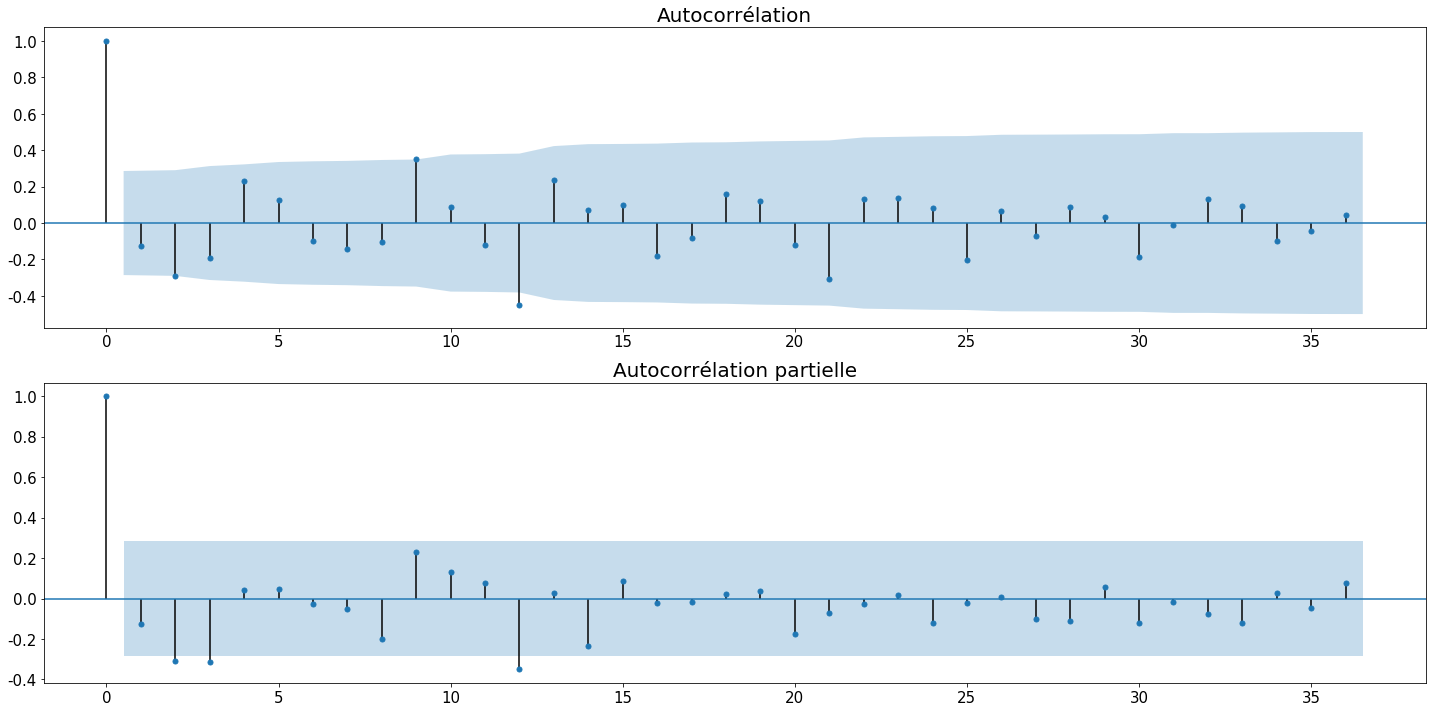

In [344]:
fig, ax = plt.subplots(2,1,figsize=(20, 10))
axes= plt.gca()
fig = sm.graphics.tsa.plot_acf(np.asarray(y_dif_12[13:]), lags=36, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(np.asarray(y_dif_12[13:]),method='ywm',  lags=36, ax=ax[1])
ax[0].set_title("Autocorrélation",fontsize=20)
ax[1].set_title("Autocorrélation partielle",fontsize=20)
ax[0].set_xticklabels([0,0,5,10,15,20,25,30,35],fontsize = 15)
ax[1].set_xticklabels([0,0,5,10,15,20,25,30,35],fontsize = 15)
ax[0].set_yticklabels([0, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize = 15)
ax[1].set_yticklabels([0, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0],fontsize = 15)
fig.patch.set_alpha(0)
plt.tight_layout()
plt.savefig("11_deter_model1.png")
plt.show()

Paramètres SARIMA : 
- p/P : lag a partir duquel ce n'est plus significatif (PACF) p:3 P:0 (pas de saisonnalité)
- q/Q : lag a partir duquel ce n'est plus significatif (ACF) q:2 Q:0 (pas de saisonnalité)
- d/D : nombre de différenciation pour stationnariser la série d:0  D:1 (plus dans l'ACF après une désaisonnalisation
- s : 12 (annuel) 

In [345]:
#modèle 1 
model1 = SARIMAX(np.asarray(dataQ1FinalPrev["Consomation corrigée"]), order=(3,0,2), seasonal_order=(0,1,0,12),
                return_df =True)
results1 = model1.fit()
print(results1.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results1.resid, lags=elt)[1].mean()))

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   60
Model:             SARIMAX(3, 0, 2)x(0, 1, [], 12)   Log Likelihood                -396.808
Date:                             Sat, 12 Dec 2020   AIC                            805.616
Time:                                     09:20:24   BIC                            816.843
Sample:                                          0   HQIC                           809.859
                                              - 60                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3932      0.130      3.029      0.002       0.139       0.648
ar.L2         -0.9752      

E:\Python\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
E:\Python\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


#### Identification manuelle 2 

In [346]:
#modèle 2 
model2= SARIMAX(np.asarray(dataQ1FinalPrev["Consomation corrigée"]), order=(1,1,1), seasonal_order=(1,1,1,12),
                return_df =True)
results2= model2.fit()
print(results2.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results2.resid, lags=elt)[1].mean()))

E:\Python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
E:\Python\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -411.708
Date:                            Sat, 12 Dec 2020   AIC                            833.416
Time:                                    09:20:24   BIC                            842.667
Sample:                                         0   HQIC                           836.897
                                             - 60                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3377      0.449      0.752      0.452      -0.543       1.219
ma.L1         -0.4817      0.443   

In [347]:
#modèle 2 
model2= SARIMAX(np.asarray(dataQ1FinalPrev["Consomation corrigée"]), order=(0,1,1), seasonal_order=(1,1,1,12),
                return_df =True)
results2= model2.fit()
print(results2.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results2.resid, lags=elt)[1].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   60
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -412.243
Date:                            Sat, 12 Dec 2020   AIC                            832.486
Time:                                    09:20:25   BIC                            839.887
Sample:                                         0   HQIC                           835.271
                                             - 60                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1397      0.052     -2.682      0.007      -0.242      -0.038
ar.S.L12       0.6950      0.129   

#### Identification  Automatique 

In [348]:
#modèle 1 
modelAuto=pm.auto_arima(np.asarray(dataQ1FinalPrev["Consomation corrigée"]), start_p=1, start_q=1,
                         test='adf',
                         max_p=4, max_q=4, m=12,
                         start_P=1, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)
print(modelAuto.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=813.050, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=816.448, Time=0.06 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=816.382, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=811.911, Time=0.01 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=814.904, Time=0.05 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=814.898, Time=0.03 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=814.515, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=814.489, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=817.384, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12]          
Total fit time: 1.110 seconds
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   60

AIC et BIC plus bas, meilleur modèle 

In [349]:
#modèle pred
modelAuto= SARIMAX(np.asarray(dataQ1FinalPrev["Consomation corrigée"]), order=(0,0,0), seasonal_order=(0,1,0,12),
               return_df =True)
resultsAuto= modelAuto.fit()
print(resultsAuto.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(resultsAuto.resid, lags=elt)[1].mean()))

                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   60
Model:             SARIMAX(0, 1, 0, 12)   Log Likelihood                -404.955
Date:                  Sat, 12 Dec 2020   AIC                            811.911
Time:                          09:20:26   BIC                            813.782
Sample:                               0   HQIC                           812.618
                                   - 60                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.236e+06   2.36e+05      5.233      0.000    7.73e+05     1.7e+06
Ljung-Box (Q):                       82.12   Jarque-Bera (JB):                 0.32
Prob(Q):                       

E:\Python\lib\site-packages\statsmodels\stats\diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


modèle 2 Blacnheur résidus et et significativité des paramètres OK

### Validité du modèle (blancheur des résidus)

#### Normalité 

In [350]:
#Normalité des résidus
shapiro(results1.resid)

(0.5677977800369263, 5.080709724464283e-12)

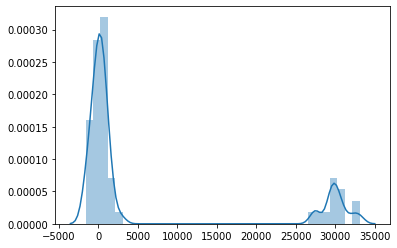

In [351]:
sns.distplot(results1.resid)

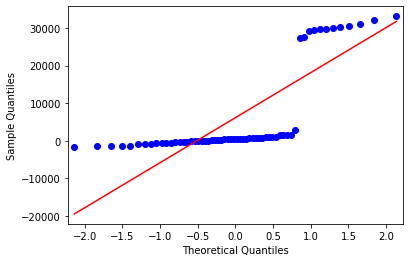

In [352]:
sm.ProbPlot(results1.resid).qqplot(line='s');

In [353]:
shapiro(results2.resid)

(0.4909263253211975, 4.121721139307283e-13)

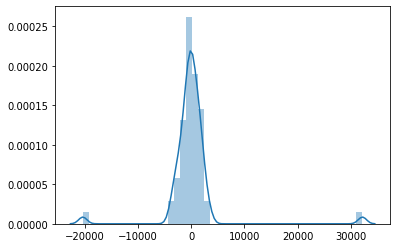

In [354]:
sns.distplot(results2.resid)

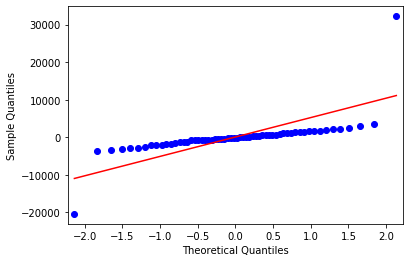

In [355]:
sm.ProbPlot(results2.resid).qqplot(line='s');

In [356]:
shapiro(resultsAuto.resid)

(0.5823017358779907, 8.446949736895526e-12)

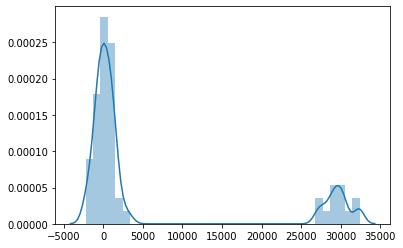

In [357]:
sns.distplot(resultsAuto.resid)

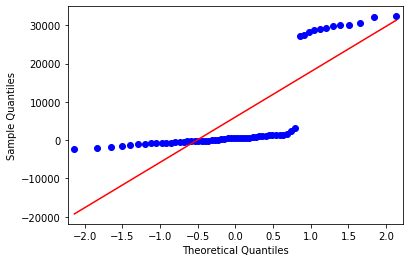

In [358]:
sm.ProbPlot(resultsAuto.resid).qqplot(line='s');

#### Auto corrélation

E:\Python\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


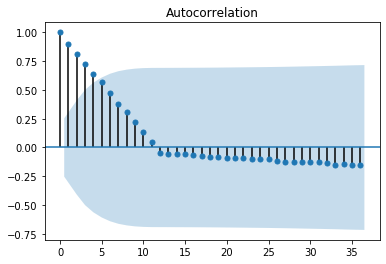

In [359]:
#auto-corrélation serie/lag
acf= smt.graphics.plot_acf(results1.resid, lags=36)
acf.show()

E:\Python\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


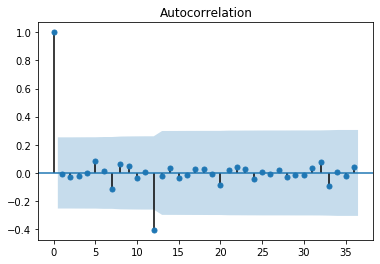

In [360]:
#auto-corrélation serie/lag
acf= smt.graphics.plot_acf(results2.resid, lags=36)
acf.show()

E:\Python\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


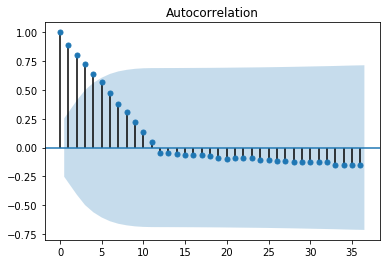

In [361]:
#auto-corrélation serie/lag
acf= smt.graphics.plot_acf(resultsAuto.resid, lags=36)
acf.show()

### Prévision

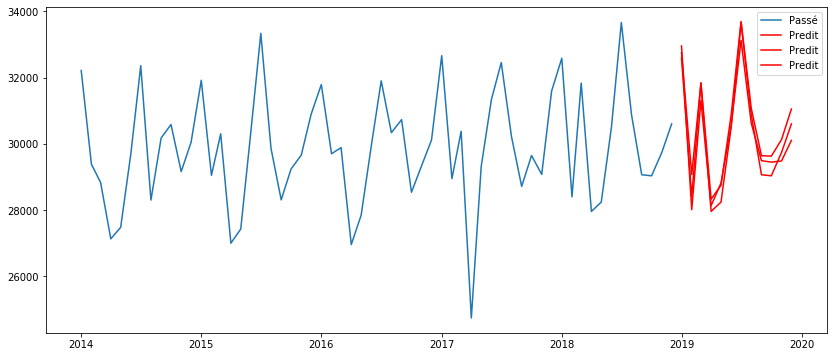

In [362]:
pred_model1 = results1.get_forecast(12)
pred1 =pred_model1.predicted_mean
pred_model2 = results2.get_forecast(12)
pred2 =pred_model2.predicted_mean
pred_modelAuto = resultsAuto.get_forecast(12)
predAuto =pred_modelAuto.predicted_mean
pred_l = [elt[0] for elt in pred_model2.conf_int(alpha=0.1)]
pred_u = [elt[1] for elt in pred_model2.conf_int(alpha=0.1)]

plt.figure(figsize=(14,6))
plt.plot(dataQ1FinalPrev["Consomation corrigée"], label='Passé')
plt.plot(pd.date_range(dataQ1FinalPrev.index[len(dataQ1FinalPrev)-1], periods=12, freq='M'), pred1, color='r', label='Predit')
plt.plot(pd.date_range(dataQ1FinalPrev.index[len(dataQ1FinalPrev)-1], periods=12, freq='M'), pred2, color='r', label='Predit')
plt.plot(pd.date_range(dataQ1FinalPrev.index[len(dataQ1FinalPrev)-1], periods=12, freq='M'), predAuto, color='r', label='Predit')
#plt.plot(pd.date_range(dataQ1FinalPrev.index[len(dataQ1FinalPrev)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--')
#plt.plot(pd.date_range(dataQ1FinalPrev.index[len(dataQ1FinalPrev)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')

plt.legend()
plt.show()

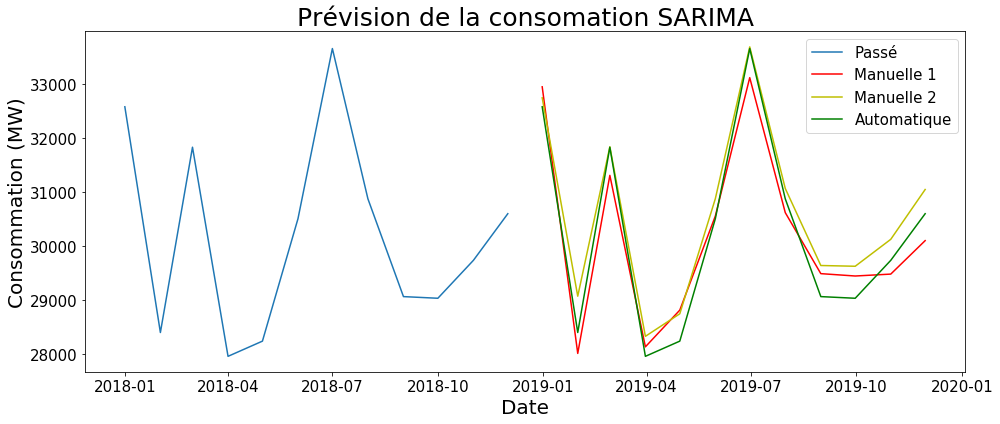

In [363]:
fig = plt.figure(figsize=(14,6))
plt.plot(dataQ1FinalPrev["Consomation corrigée"]["2018":], label='Passé')
plt.plot(pd.date_range(dataQ1FinalPrev.index[len(dataQ1FinalPrev)-1], periods=12, freq='M'), pred1, color='r', label='Manuelle 1')
plt.plot(pd.date_range(dataQ1FinalPrev.index[len(dataQ1FinalPrev)-1], periods=12, freq='M'), pred2, color='y', label='Manuelle 2')
plt.plot(pd.date_range(dataQ1FinalPrev.index[len(dataQ1FinalPrev)-1], periods=12, freq='M'), predAuto, color='g', label='Automatique')

#plt.plot(pd.date_range(dataQ1FinalPrev.index[len(dataQ1FinalPrev)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--')
#plt.plot(pd.date_range(dataQ1FinalPrev.index[len(dataQ1FinalPrev)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.title("Prévision de la consomation SARIMA",fontsize = 25)
plt.xlabel("Date")
plt.ylabel("Consommation (MW)")
axes= plt.gca()
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.legend(fontsize=15)
fig.patch.set_alpha(0)
plt.savefig('13_prev_SARIMA_Q32.png')
plt.show()


### A posteriori

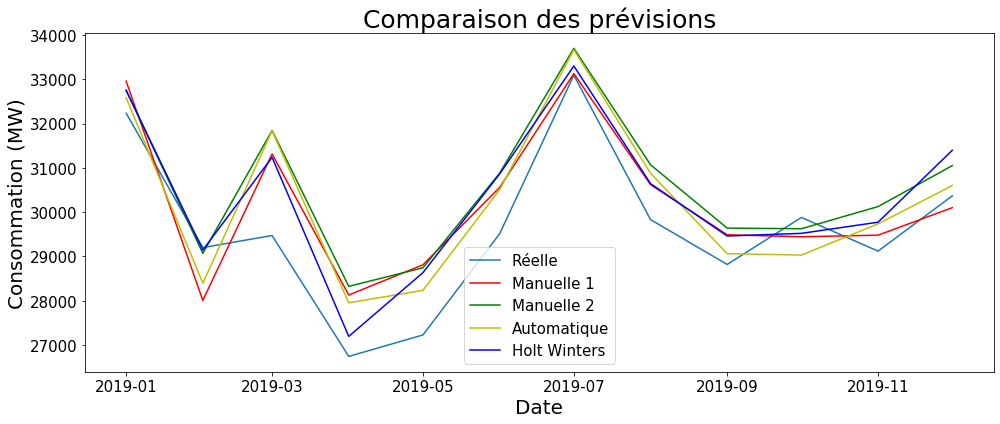

In [364]:
fig = plt.figure(figsize=(14,6))
plt.plot(dataQ1FinalReel["Consomation corrigée"], label='Réelle')
plt.plot(dataQ1FinalReel.index, pred1, color='r', label='Manuelle 1')
plt.plot(dataQ1FinalReel.index, pred2, color='g', label='Manuelle 2')
plt.plot(dataQ1FinalReel.index, predAuto, color='y', label='Automatique')
plt.plot(dataQ1FinalReel.index, hw_pred, color='b', label='Holt Winters')
#plt.plot(dataQ1FinalReel.index, pred_l, color='g', linestyle='--', label='int95%_inf')
#plt.plot(dataQ1FinalReel.index, pred_u, color='g', linestyle='--', label='int95%_sup')
plt.title("Comparaison des prévisions",fontsize = 25)
plt.xlabel("Date")
plt.ylabel("Consommation (MW)")
axes= plt.gca()
axes.xaxis.label.set_size(20)
axes.yaxis.label.set_size(20)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.legend(fontsize=15)
fig.patch.set_alpha(0)
plt.savefig('14_comparaison_prev.png')
plt.show()


### MAPE

In [365]:
mape (dataQ1FinalReel["Consomation corrigée"].values,pred1)

2.9778497422330745

In [366]:
mape (dataQ1FinalReel["Consomation corrigée"].values,pred2)

3.463589945866004

In [367]:
mape (dataQ1FinalReel["Consomation corrigée"].values,predAuto)

2.937042230469318

In [368]:
mape (dataQ1FinalReel["Consomation corrigée"].values,hw_pred)

2.632005914970815